In [88]:
from typing import Tuple, List
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import pickle
from tensorflow import keras
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, multilabel_confusion_matrix

from evaluation.serialization import Serializer
from constants import TYPES, annotation_mapping, reverse_annotation_mapping, amino_acid_mapping
from utils.encoding import sequenceToCategorical, categoricalToOneHot, categoricalToSequence, oneHotToCategorical
from utils.Dataset import Dataset
from utils.helpers import getDatasetPath

In [3]:
run_timestamp = "20211113-1438"
base_path = f"../../results/{run_timestamp}/"
final_model = keras.models.load_model(base_path + f"models/final_model.h5")

test_data = Dataset(getDatasetPath()).getFolds([0])

test_x = np.array([categoricalToOneHot(sequenceToCategorical(seq, amino_acid_mapping), amino_acid_mapping) for seq in test_data["sequence"]])
predictions = final_model.predict(test_x)

test_data["prediction"] = np.array([categoricalToSequence(oneHotToCategorical(pred), reverse_annotation_mapping) for pred in predictions])

In [4]:
def getRelevantData(query: str) -> Tuple[np.ndarray, np.ndarray]:
    relevant_data = test_data.query(query)
    y_pred = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["prediction"]])
    y_true = np.array([sequenceToCategorical(seq, annotation_mapping) for seq in relevant_data["annotation"]])

    return (y_pred, y_true)

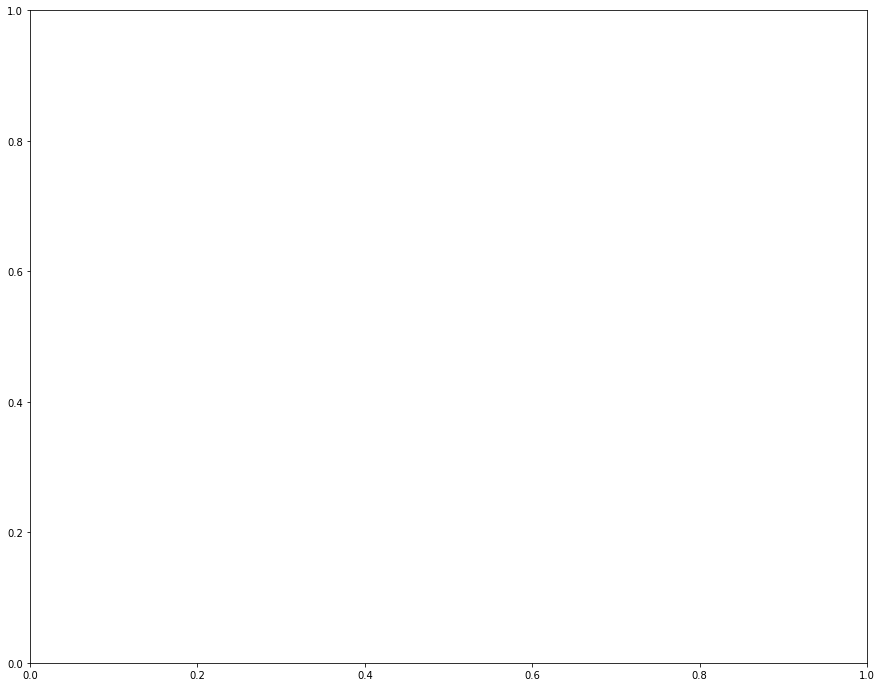

In [57]:
(y_pred, y_true) = getRelevantData("index == index")
fig, ax = plt.subplots(figsize=(15,12))

annotation_labels = [c for c in "STLIMO"]
whole_cm = pd.DataFrame(
    confusion_matrix(y_true.flatten(), y_pred.flatten()),
    index = annotation_labels,
    columns = annotation_labels
)

In [92]:
def generateBinaryConfusionMatrix(
        class1: List[str], class2: List[str],
        labels: List[str],
        title: str,filename: str) -> None:

    data = np.array([
        [whole_cm.loc[class1, class1].sum().sum(), whole_cm.loc[class1, class2].sum().sum()],
        [whole_cm.loc[class2, class1].sum().sum(), whole_cm.loc[class2, class2].sum().sum()]
    ])

    df = pd.DataFrame(data, index=labels, columns=labels)

    plotConfusionMatrix(df, title, filename)


In [93]:
def plotConfusionMatrix(confusion_matrix: np.ndarray, title: str, filename: str) -> None:
    # Create dataframe with relative values
    cm = confusion_matrix.copy()
    cm_ratio = cm.applymap(lambda x: x / cm.sum().sum())

    fig, ax = plt.subplots(figsize=(12,12))

    # Absolute values
    sns.heatmap(
        cm,
        annot=True, fmt="d",
        annot_kws={"va": "bottom"},
        linewidths=2,
        norm=matplotlib.colors.LogNorm(),
        cmap="BuPu",
        ax=ax
    )

    # Percentage values on top
    sns.heatmap(
        cm_ratio,
        linewidths=2,
        annot=True,
        annot_kws={"va": "top"},
        fmt=".2%",
        norm=matplotlib.colors.LogNorm(),
        cmap="BuPu",
        cbar=False,
        ax=ax
    )

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    fig.set_size_inches(4, 3)
    fig.tight_layout()
    fig.savefig(f"output/{filename}.png", dpi=240)

### SPs vs. non-SPs

In [ ]:
sp_labels = ['S', 'T', 'L']
non_sp_labels = ['I', 'M', 'O']
generateBinaryConfusionMatrix(sp_labels, non_sp_labels, ["SP", "no SP"], "SP vs. non-SP", "confusion_matrix_sp_vs_non_sp")

### Tat vs. Sec/SPI&II

In [ ]:
generateBinaryConfusionMatrix(["T"], ["S", "L"], ["Tat", "Sec/SPI&II"], "Tat vs. Sec/SPI&II", "confusion_matrix_tat_vs_sec")

### Sec/SPI vs. Sec/SPII

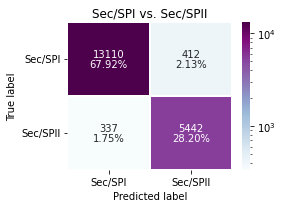

In [96]:
generateBinaryConfusionMatrix(["S"], ["L"], ["Sec/SPI", "Sec/SPII"], "Sec/SPI vs. Sec/SPII", "confusion_matrix_secsp1_vs_secsp2")

### Transmembrane vs. Cytoplasm&Extracellular

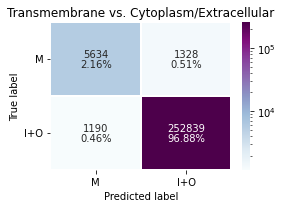

In [97]:
generateBinaryConfusionMatrix(
    ["M"], ["I", "O"],
    ["M", "I+O"],
    "Transmembrane vs. Cytoplasm/Extracellular",
    "confusion_matrix_transmembrane_vs_cytoplasm_and_extracellular"
)

### Cytoplasm vs. Extracellular

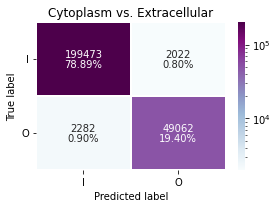

In [99]:
generateBinaryConfusionMatrix(
    ["I"], ["O"],
    ["I", "O"],
    "Cytoplasm vs. Extracellular",
    "confusion_matrix_cytoplasm_vs_extracellular"
)
